## LIBRERIAS y CONSTANTES

In [1]:
import numpy as np
import pandas as pd
import pickle
import torch.nn as nn
from torch.utils.data import DataLoader
import json, ast, sys, csv, random
import plotly.express as px
import math
import datetime
import sys
import csv

#Implement training process
#from model_trees_algebra import NeoRegression

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from functions.tree_format import IterateBuildTree, InnerJoinsIntraBGPS, \
                                IterateBuildTreeBetweenBGPS, TreeFormat, TreeFormat_all
from functions.RL_functions import GetTriplesSubtree, \
                                        GetTreeSize, \
                                        GetAllJoins, \
                                        GetIter, \
                                        GetTotalBgp, \
                                        GetDataframe

from functions.aux import MetricTotalAccuraccy


class BaoTrainingException(Exception):
    pass
csv.field_size_limit(sys.maxsize)


131072

### Basic parameters

In [2]:
URL = "/media/data/ccarmona/memoria/dataset/"
csv_name = 'new_dataset_7.2_subqueries'
symbol = "ᶲ"
min1, max1 = 50, 150
min2, max2 = 1,150
#Este parametro sirve para elegir cierta cantidad de data ordenado por rangos de tiempo obtenidos.
## Entre más bajo menos data se seleccionara. Si es muy alto se tendran demasiados valores outliners, 
## pero si es muy bajo podría tenerse una data no representativa y se aumenta el riesgo de overfitting.
## Por otro lado min_data, simplemente da el valor minimo de tiempo de ejecución que tiene una consulta tomada
## en cuenta para hacer el modelo
#percent_of_data_or = 0.93
#min_time_or = 15
#max_time_or = 80
#percent_of_data = 1
#min_time = 5
#max_time = 80


In [3]:
def split_ds(all_data, val_rate, seed):
    """
    Used  to keep a balance of sets with respect to runtime of queries. 
    test_rate is a rate of the total,
    val_rate is a rate of the (total - test_rate)
    :param all_data: Pandas dataframe with data
    :param val_rate: Rate of the (total - test_rate)
    :param seed: For replication of results, this fixes the seed of split method. 
    :return: 
    """
    ranges = {}
    ranges['1_2'] = all_data[(all_data["time"] > 0)    & (all_data["time"] <= 2)]
    ranges['2_3'] = all_data[(all_data["time"] > 2)    & (all_data["time"] <= 3)]
    ranges['3_4'] = all_data[(all_data["time"] > 3)    & (all_data["time"] <= 4)]
    ranges['4_5'] = all_data[(all_data["time"] > 4)    & (all_data["time"] <= 5)]
    ranges['5_8'] = all_data[(all_data["time"] > 5)    & (all_data["time"] <= 8)]
    ranges['8_10'] = all_data[(all_data["time"] > 8)   & (all_data["time"] <= 10)]
    ranges['10_20'] =   all_data[(all_data["time"] > 10) & (all_data["time"] <= 20)]
    ranges['20_30'] =   all_data[(all_data["time"] > 20) & (all_data["time"] <= 30)]
    ranges['30_40'] =   all_data[(all_data["time"] > 30) & (all_data["time"] <= 40)]
    ranges['40_50'] =   all_data[(all_data["time"] > 40) & (all_data["time"] <= 50)]
    ranges['50_60'] =   all_data[(all_data["time"] > 50) & (all_data["time"] <= 60)]
    ranges['60_80'] =   all_data[(all_data["time"] > 60) & (all_data["time"] <= 80)]
    ranges['80_100'] =  all_data[(all_data["time"] > 80) & (all_data["time"] <= 100)]
    ranges['100_150'] = all_data[(all_data["time"] > 100) & (all_data["time"] <= 150)]
    ranges['150_200'] = all_data[(all_data["time"] > 150) & (all_data["time"] <= 200)]
    ranges['200_250'] = all_data[(all_data["time"] > 200) & (all_data["time"] <= 250)]
    ranges['250_450'] = all_data[(all_data["time"] > 250) & (all_data["time"] <= 450)]
    ranges['450_last'] = all_data[(all_data["time"] > 450)]
    train_data = []
    val_data = []
    for rang in ranges.values():
        if rang.shape[0] >= 3:
            X_train, X_val = train_test_split(
                rang, test_size=val_rate, shuffle=True,random_state=seed)

            train_data.append(X_train)
            val_data.append(X_val)
    train_data_list = pd.concat(train_data)
    val_data_list = pd.concat(val_data)
    #print("Shapes : Train: {} Val: {}".format(train_data_list.shape, val_data_list.shape))
    return train_data_list, val_data_list
def clear_error_tuples(x):
    try:
        json.loads(x)
        return True
    except:
        print("Error in data ignored!", x)
        return False
    
def subtree_format(df_raw):
    df_raw_unique_id = df_raw['unique_id']
    df_raw_filename = df_raw['filename']
    df_raw_query = df_raw['query']
    df_raw_bgp = df_raw['bgps']
    df_raw_json_cardinality = df_raw['json_cardinality']
    df_raw_subtrees = df_raw['matrix_subtrees']
    columns = ['unique_id', 'filename', 'query', 'trees',  'bgps' ,'time', 'total_bgps', 'triples', 'treesize', 'join', 'left_join', 'iter', 'json_cardinality_original_query']
    values = []
    for dfrs in range(0,len(df_raw_subtrees)):
        unique_id = df_raw_unique_id[dfrs]
        filename = df_raw_filename[dfrs]
        query = df_raw_query[dfrs]
        bgp = df_raw_bgp[dfrs]
        json_cardinality = df_raw_json_cardinality[dfrs]
        lists_type = ast.literal_eval(df_raw_subtrees[dfrs])
        for ls in lists_type:
            str_subtree = str(ls[0]).replace('"', ';').replace("'", '"')
            row = [unique_id, filename, query, str_subtree, bgp] + ls[1:] + [json_cardinality]
            values.append(row)
            
    df_subtrees = pd.DataFrame(values, columns=columns)
    return df_subtrees
    

### Features

In [4]:
# Columns to use.
list_columns = ['total_bgps', 'triples', 'treesize', 'join', 'left_join']

## IDENTIFICACION DE DATASET, CLEAN DATA Y CREAR NEW DATASET

In [5]:
df_raw = pd.read_csv(URL + csv_name + ".csv", engine='python', encoding='utf-8')

In [6]:
df_raw.columns

Index(['unique_id', 'filename', 'query', 'profile', 'limit', 'group_by',
       'distinct', 'order_by', 'union', 'left_join', 'join', 'iter', 'filter',
       'num_filter', 'filter_eq', 'filter_gt', 'filter_ge', 'filter_lt',
       'filter_le', 'filter_neq', 'filter_iri', 'filter_neq.1', 'filter_bound',
       'filter_contains', 'filter_exists', 'filter_isBlank', 'filter_isIRI',
       'filter_isLiteral', 'filter_lang', 'filter_langMatches', 'filter_not',
       'filter_notexists', 'filter_regex', 'filter_sameTerm', 'filter_str',
       'filter_strstarts', 'filter_or', 'filter_and', 'time', 'cpu_p', 'rnd',
       'seq', 'same_seg_p', 'same_page_p', 'disk_reads', 'read_ahead', 'wait',
       'comp_msec', 'comp_reads', 'comp_read_p', 'comp_messages', 'comp_clw',
       'triples', 'total_bgps', 'treesize', 'matrix_format', 'trees',
       'trees_old_format', 'json_time_predicate', 'json_fanout_predicate',
       'json_input_rows_predicate', 'json_cardinality_fanout',
       'json_cardinal

In [7]:
df_raw = df_raw.drop(['trees'],axis=1)
df_raw = df_raw.drop(['matrix_subtrees'],axis=1)
df_raw.rename(columns={'trees_old_format': 'trees'}, inplace=True)
df_raw.rename(columns={'matrix_subtrees_full': 'matrix_subtrees'}, inplace=True)

In [8]:
print("df_raw.shape", df_raw.shape)
df_raw['time'].value_counts(bins=100, sort=True, normalize=True)

df_raw.shape (53887, 65)


(-15441.387, 154413.86]     0.998682
(154413.86, 308827.72]      0.000390
(308827.72, 463241.58]      0.000186
(2007380.18, 2161794.04]    0.000186
(1235310.88, 1389724.74]    0.000111
                              ...   
(6485382.12, 6639795.98]    0.000000
(6330968.26, 6485382.12]    0.000000
(6176554.4, 6330968.26]     0.000000
(6022140.54, 6176554.4]     0.000000
(7720693.0, 7875106.86]     0.000000
Name: time, Length: 100, dtype: float64

In [9]:
print(df_raw['time'].describe())
df_raw = df_raw[df_raw['time'] >= 1]
df_raw = df_raw[df_raw['time'] <= 200]
print(df_raw['time'].describe())
print(print("df_raw.shape", df_raw.shape))

count    5.388700e+04
mean     2.611200e+03
std      1.078120e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+01
75%      4.900000e+01
max      1.544139e+07
Name: time, dtype: float64
count    33271.000000
mean        33.550509
std         40.816332
min          1.000000
25%          6.000000
50%         15.000000
75%         48.000000
max        200.000000
Name: time, dtype: float64
df_raw.shape (33271, 65)
None


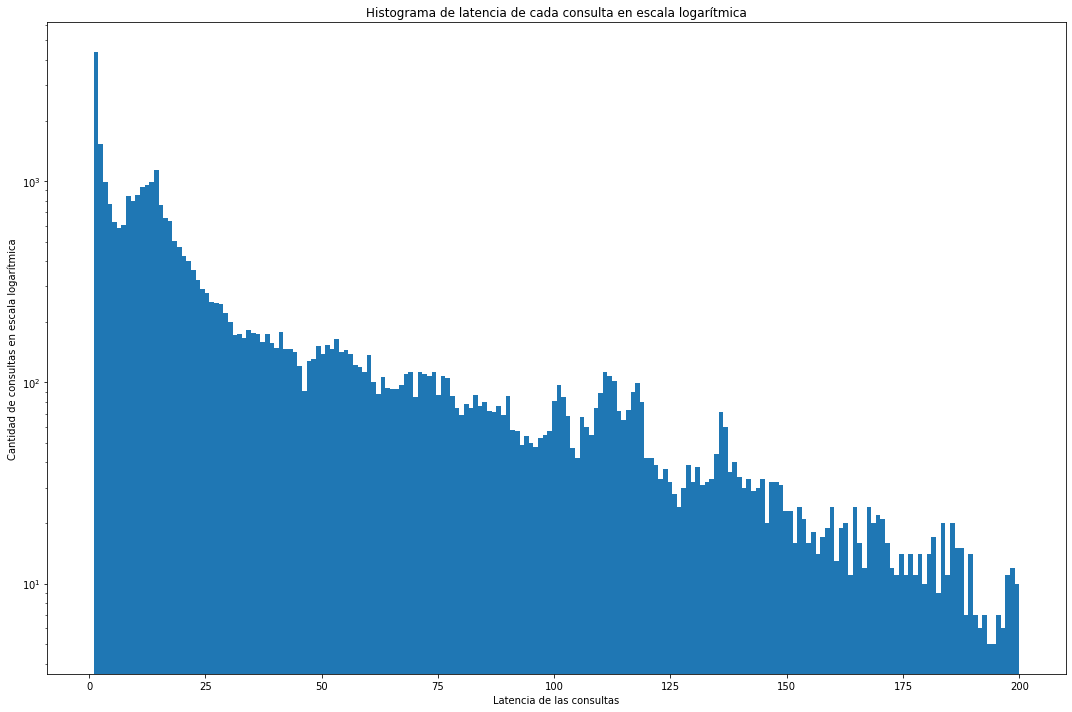

In [10]:
import matplotlib.pyplot as plt
import numpy as np
df_time_analysis = df_raw['time'].copy()
df_time_analysis = df_time_analysis.to_numpy()

f,ax = plt.subplots(figsize=(15,10))

ax.hist(df_time_analysis, bins=200)
ax.set_title("Histograma de latencia de cada consulta en escala logarítmica")
ax.set_xlabel("Latencia de las consultas")
ax.set_ylabel("Cantidad de consultas en escala logarítmica")
ax.set_yscale('log')
plt.tight_layout()
plt.savefig("histograma_latencia_consultas.pdf")

In [11]:
print("mean", df_raw['time'].mean())
print("std", df_raw['time'].std())
print('df_raw.shape',df_raw.shape)
print("max", df_raw['time'].max())
print("df_raw.shape", df_raw.shape)
df_raw = df_raw[df_raw['time'] >= min1]
df_raw = df_raw[df_raw['time'] <= max1]
df_raw = df_raw.reset_index(drop=True)
print("CLEAN by TIME")
print("mean", df_raw['time'].mean())
print("std", df_raw['time'].std())
print("max", df_raw['time'].max())
print("df_raw.shape", df_raw.shape)

mean 33.55050945267651
std 40.81633220560009
df_raw.shape (33271, 65)
max 200
df_raw.shape (33271, 65)
CLEAN by TIME
mean 88.20585842148088
std 27.65766366258196
max 150
df_raw.shape (7374, 65)


In [12]:
c = 0
ds = df_raw.copy()
for i in range(ds.shape[0]):
    if ds['query'][i].count("OPTIONAL") == 1 and ds['total_bgps'][i] == 2 and ds['triples'][i] == 4:
        print(ds['query'][i])
        print(ds['filename'][i])
        print("------------------")
        c+=1
print(c)

SELECT ?var1 ?var2 WHERE { ?var1 <http://www.wikidata.org/prop/direct/P131> ?var3 . ?var3 <http://www.wikidata.org/prop/direct/P131> * <http://www.wikidata.org/entity/Q1273> . ?var1 <http://www.wikidata.org/prop/direct/P625> ?var2 . OPTIONAL { ?var1 <http://www.wikidata.org/prop/direct/P18> ?var4 . } }

query_960
------------------
SELECT  ?var1 ?var2 WHERE   { ?var1  <http://www.wikidata.org/prop/direct/P971>  <http://www.wikidata.org/entity/Q31192219>     OPTIONAL       { ?var1  <http://www.wikidata.org/prop/direct/P971>  ?var2 .         ?var2 <http://www.wikidata.org/prop/direct/P31>/<http://www.wikidata.org/prop/direct/P279> <http://www.wikidata.org/entity/Q82794>       }   } 

query_22528
------------------
SELECT ?var1 ?var2 WHERE { ?var1 <http://www.wikidata.org/prop/direct/P131> ?var3 . ?var3 <http://www.wikidata.org/prop/direct/P131> * <http://www.wikidata.org/entity/Q1273> . ?var1 <http://www.wikidata.org/prop/direct/P625> ?var2 . OPTIONAL { ?var1 <http://www.wikidata.org/pro

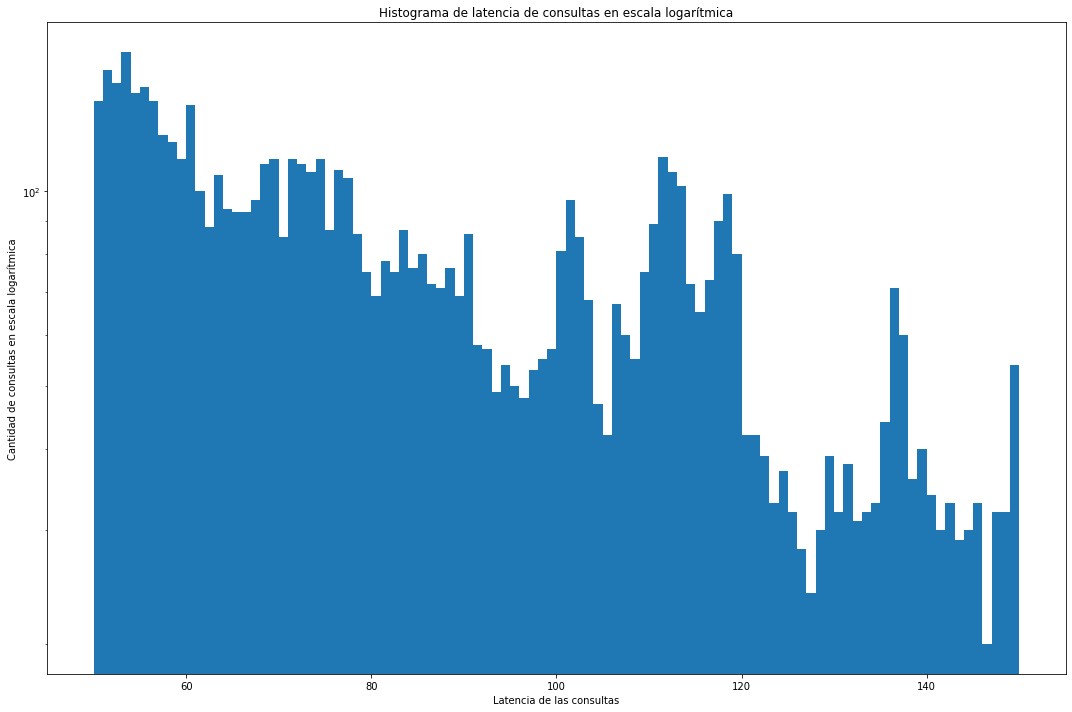

In [13]:
import matplotlib.pyplot as plt
import numpy as np
df_time_analysis2 = df_raw['time'].copy()
df_time_analysis2 = df_time_analysis2.to_numpy()

f,ax = plt.subplots(figsize=(15,10))

ax.hist(df_time_analysis2, bins=100)
ax.set_title("Histograma de latencia de consultas en escala logarítmica")
ax.set_xlabel("Latencia de las consultas")
ax.set_ylabel("Cantidad de consultas en escala logarítmica")
ax.set_yscale('log')
plt.tight_layout()
plt.savefig("histograma_latencia_consultas_corte.pdf")

In [14]:
if 'sparql_file' in df_raw.columns:
    df_raw = df_raw.rename(columns = {'sparql_file': 'query'}, inplace = False)
df_raw['cpu_p'] = df_raw['cpu_p'].apply(lambda x: float(x.strip('%')))
df_raw['same_seg_p'] = df_raw['same_seg_p'].apply(lambda x: float(x.strip('%')))
df_raw['same_page_p'] = df_raw['same_page_p'].apply(lambda x: float(x.strip('%')))
df_raw['wait'] = df_raw['wait'].apply(lambda x: float(x.strip('%')))
df_raw['comp_read_p'] = df_raw['comp_read_p'].apply(lambda x: float(x.strip('%')))
df_raw['comp_clw'] = df_raw['comp_clw'].apply(lambda x: float(x.strip('%')))

In [15]:
df_raw['time'].describe()

count    7374.000000
mean       88.205858
std        27.657664
min        50.000000
25%        64.000000
50%        83.000000
75%       111.000000
max       150.000000
Name: time, dtype: float64

In [16]:
ds_model, ds_rl_prev = split_ds(df_raw, 0.25,seed=None)
ds_model = ds_model.reset_index(drop=True)
ds_rl_prev = ds_rl_prev.reset_index(drop=True)
print("ds_model.shape",ds_model.shape)
print("ds_rl_prev.shape",ds_rl_prev.shape)

ds_model.shape (5529, 65)
ds_rl_prev.shape (1845, 65)


In [17]:
df_subtrees = subtree_format(ds_model)
df_subtrees['time'] = df_subtrees.time.astype(float)
print(ds_model.shape)
print(df_subtrees.shape)

(5529, 65)
(13000, 13)


In [18]:
df_subtrees['time'].describe()

count    13000.000000
mean        52.093685
std         44.990023
min          0.024522
25%          1.110064
50%         55.000000
75%         86.619756
max        150.000000
Name: time, dtype: float64

In [19]:
df_subtrees = df_subtrees[df_subtrees['time'] >= min2]
df_subtrees = df_subtrees[df_subtrees['time'] <= max2]
df_subtrees = df_subtrees.reset_index(drop=True)
df_subtrees['time'].describe()

count    9804.000000
mean       68.971178
std        39.054106
min         1.003711
25%        45.400701
50%        69.676296
75%        99.000000
max       150.000000
Name: time, dtype: float64

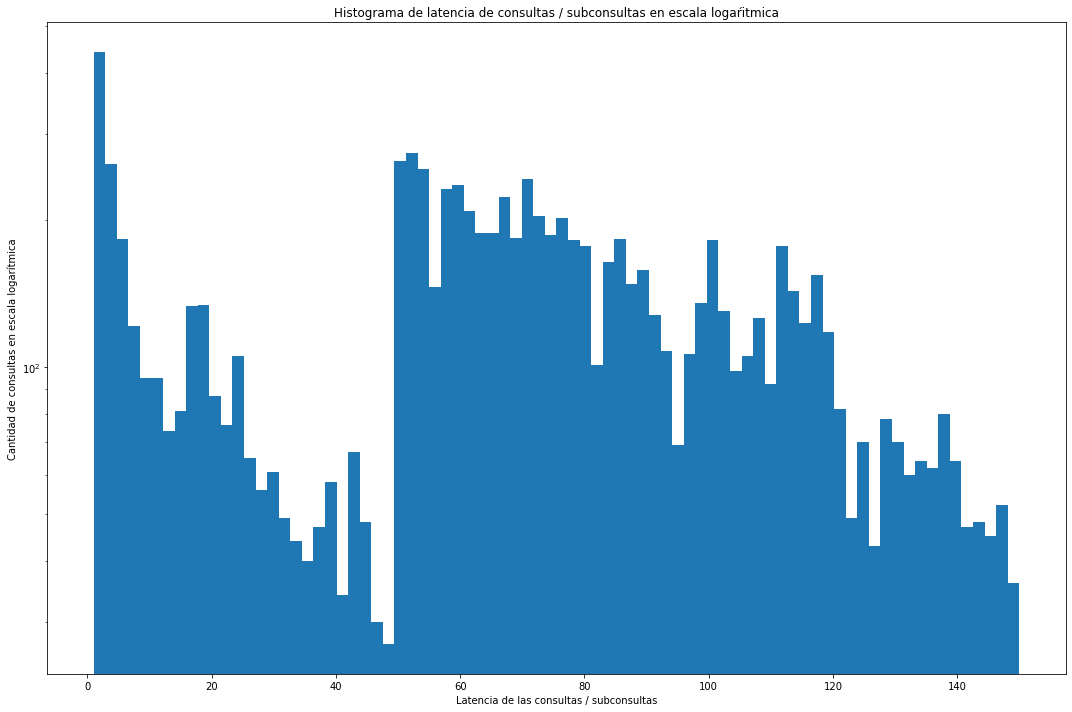

In [20]:
import matplotlib.pyplot as plt
import numpy as np
df_time_analysis3 = df_subtrees['time'].copy()
df_time_analysis3 = df_time_analysis3.to_numpy()

f,ax = plt.subplots(figsize=(15,10))

ax.hist(df_time_analysis3, bins=80)
ax.set_title("Histograma de latencia de consultas / subconsultas en escala logaŕitmica")
ax.set_xlabel("Latencia de las consultas / subconsultas")
ax.set_ylabel("Cantidad de consultas en escala logarítmica")
ax.set_yscale('log')
plt.tight_layout()
plt.savefig("histograma_latencia_subconsultas.pdf")

In [21]:
ds_train_val_prev, ds_test_prev = split_ds(df_subtrees, 0.15,seed=None)
ds_train_prev, ds_val_prev = split_ds(ds_train_val_prev, 0.1765,seed=None)
print("ds_train_val_prev.shape",ds_train_val_prev.shape)
print("ds_test_prev.shape",ds_test_prev.shape)
print("ds_train_prev.shape",ds_train_prev.shape)
print("ds_val_prev.shape",ds_val_prev.shape)
ds_train_prev = ds_train_prev.reset_index()
ds_val_prev = ds_val_prev.reset_index()
ds_test_prev = ds_test_prev.reset_index()
ds_rl_prev = ds_rl_prev.reset_index()

ds_train_val_prev.shape (8325, 13)
ds_test_prev.shape (1479, 13)
ds_train_prev.shape (6849, 13)
ds_val_prev.shape (1476, 13)


In [22]:
#Remove bad rows
ds_train  = ds_train_prev[ds_train_prev['trees'].apply(lambda x: clear_error_tuples(x))]
ds_val  = ds_val_prev[ds_val_prev['trees'].apply(lambda x: clear_error_tuples(x))]
ds_test  = ds_test_prev[ds_test_prev['trees'].apply(lambda x: clear_error_tuples(x))]
ds_rl = ds_rl_prev[ds_rl_prev['trees'].apply(lambda x: clear_error_tuples(x))]

print("---------SHAPES-----------")
print("----------RAW-----------")
print(f'shape df_raw: {df_raw.shape}')
print("----------PREV----------")
print(f'shape ds_train_val_prev: {ds_train_val_prev.shape}')
print(f'shape ds_train_prev: {ds_train_prev.shape}')
print(f'shape ds_val_prev: {ds_val_prev.shape}')
print(f'shape ds_test_prev: {ds_test_prev.shape}')
print(f'shape ds_rl_prev: {ds_rl_prev.shape}')
print("----------CLEAN----------")
print(f'shape ds_train: {ds_train.shape}')
print(f'shape ds_val: {ds_val.shape}')
print(f'shape ds_test: {ds_test.shape}')
print(f'shape ds_rl: {ds_rl.shape}')

---------SHAPES-----------
----------RAW-----------
shape df_raw: (7374, 65)
----------PREV----------
shape ds_train_val_prev: (8325, 13)
shape ds_train_prev: (6849, 14)
shape ds_val_prev: (1476, 14)
shape ds_test_prev: (1479, 14)
shape ds_rl_prev: (1845, 66)
----------CLEAN----------
shape ds_train: (6849, 14)
shape ds_val: (1476, 14)
shape ds_test: (1479, 14)
shape ds_rl: (1845, 66)


In [23]:
ds_train.to_csv(URL + csv_name + '_ds_train_ft.csv')
ds_val.to_csv(URL + csv_name + '_ds_val_ft.csv')
ds_test.to_csv(URL + csv_name + '_ds_test_ft.csv')
ds_rl.to_csv(URL + csv_name + '_ds_rl_ft.csv')